# Analyzing Election Data

Code for analyzing election data from [preflib.org](https://preflib.org).

In [17]:
# import the Profile class

from pref_voting.profiles import Profile
from pref_voting.profiles_with_ties import *

# import the voting methods

from pref_voting.voting_methods import *

import math
import random
import pandas as pd
from itertools import product, combinations

from functools import partial
from multiprocess import Pool, cpu_count
import pickle
import timeit

from re import findall

import copy
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

import glob


In [18]:
# Given a file in one of the Preflib Election Data  formats, 
# return a candidate map, list of rankmaps, list of rankmap counts
# and the total number of voters.
#
# For incomplete rankings (in which some voters do not rank *all* the candidates), 
# each candidate that is unranked is placed at the bottom of the voter's ranking.
#
def read_election_file(inputfile):
    #first element is the number of candidates.
    l = inputfile.readline()
    numcands = int(l.strip())
    candmap = {}
    for i in range(numcands):
        bits = inputfile.readline().strip().split(",")
        candmap[int(bits[0].strip())] = bits[1].strip()
    bits = inputfile.readline().strip().split(",")
    numvoters = int(bits[0].strip())
    sumvotes = int(bits[1].strip())
    uniqueorders = int(bits[2].strip())
    rankmaps = []
    rankmapcounts = []
    
    for i in range(uniqueorders):
        rec = inputfile.readline().strip()
        if rec.find("{") == -1:
            if rec.find(",") == -1:
                count = int(rec)
                cvote = {c-1:1 for c in candmap.keys()}
            else:
                #it is strict, just split on ,
                count = int(rec[:rec.index(",")])
                bits = rec[rec.index(",")+1:].strip().split(",")
                
                cvote = {}
                crank = 1
                for _cidx in range(len(bits)): 
                    if  int(bits[_cidx]) - 1 not in cvote.keys():
                        cvote[int(bits[_cidx]) - 1] = crank
                        crank += 1
                max_rank = max(cvote.values())

                for c in candmap.keys():
                    if c - 1 not in cvote.keys():
                        cvote[c-1] = max_rank + 1
            rankmaps.append(cvote)
            rankmapcounts.append(count)
        else: 
            count = int(rec[:rec.index(",")])
            bits = rec[rec.index(",")+1:].strip().split(",")
            cvote = {}
            crank = 1
            partial = False
            for ccand in bits:
                if ccand.find("{") != -1:
                    partial = True
                    t = ccand.replace("{","")
                    cvote[int(t.strip())-1] = crank
                elif ccand.find("}") != -1:
                    partial = False
                    t = ccand.replace("}","")
                    cvote[int(t.strip())-1] = crank
                    crank += 1
                else:
                    cvote[int(ccand.strip())-1] = crank
                    if partial == False:
                        crank += 1
                #print("cvote is", cvote)
            rankmaps.append(cvote)
            rankmapcounts.append(count)
            
    return candmap, rankmaps, rankmapcounts, numvoters


In [19]:
%%time 

# Read the election data and determine the size of the winning sets
#
# WARNING: Takes a very long time to run 
# (it runs much faster if restricting to elections with less than 1000 candidates)
SKIP = True # set to False to analyze the elections

if not SKIP: 
    e_types = [ "soc", "soi", "toc", "toi"]
    election_data_directory = './preflib-data/'
    vms = [
        split_cycle_faster,
        beat_path_faster,
        minimax, 
        copeland,
        uc_gill,
        getcha
    ]
    for election_type in e_types:
        print(election_type)
        num_profs = 0

        data_for_df = {
            "vm": list(),
            "num_cands": list(),
            "ws_size": list(),
            "ws": list(),
            "p_ws_size": list(),
            "diff_sc": list(),
            "condorcet_winner": list(),
            "election_id": list(),
        }

        preflib_mgs = list()
        num = 0

        for fname in glob.glob(election_data_directory + f"{election_type}/*.{election_type}"):

            election_id= fname.split("/")[-1].split(".")[0]
            print(election_id)
            with open(fname, 'r') as fp:
                line = fp.readline()
                num_cands = int(line)

            print(num_cands)

            if   num_cands < 1000:
                candmap, rankmaps, rankmapcounts, numvoters = read_election_file(open(fname, "r"))
                num += 1
                prof = ProfileWithTies(rankmaps, rankmapcounts)
                cw = prof.condorcet_winner()
                print(cw)
                if cw is not None:
                    winning_sets = {vm.name: [cw] for vm in vms}
                else: 
                    winning_sets = {vm.name: vm(prof) for vm in vms}

                for vm in vms: 
                    data_for_df["vm"].append(vm.name) 
                    data_for_df["num_cands"].append(num_cands) 
                    data_for_df["ws_size"].append(len(winning_sets[vm.name])) 
                    data_for_df["ws"].append(winning_sets[vm.name]) 
                    data_for_df["p_ws_size"].append((len(winning_sets[vm.name]) / num_cands) * 100) 
                    data_for_df["diff_sc"].append(winning_sets[vm.name] != winning_sets["Split Cycle"]) 
                    data_for_df["condorcet_winner"].append(cw is not None) 
                    data_for_df["election_id"].append(election_id) 

        print(f"{num=}")
        df = pd.DataFrame(data_for_df)
        df.to_csv("generated_preflib_election_data.csv", index=False)
else: 
    print("Skipped analyzing the preflib election data.")

Skipped analyzing the preflib election data.
CPU times: user 241 µs, sys: 145 µs, total: 386 µs
Wall time: 287 µs


## Generate Graphs


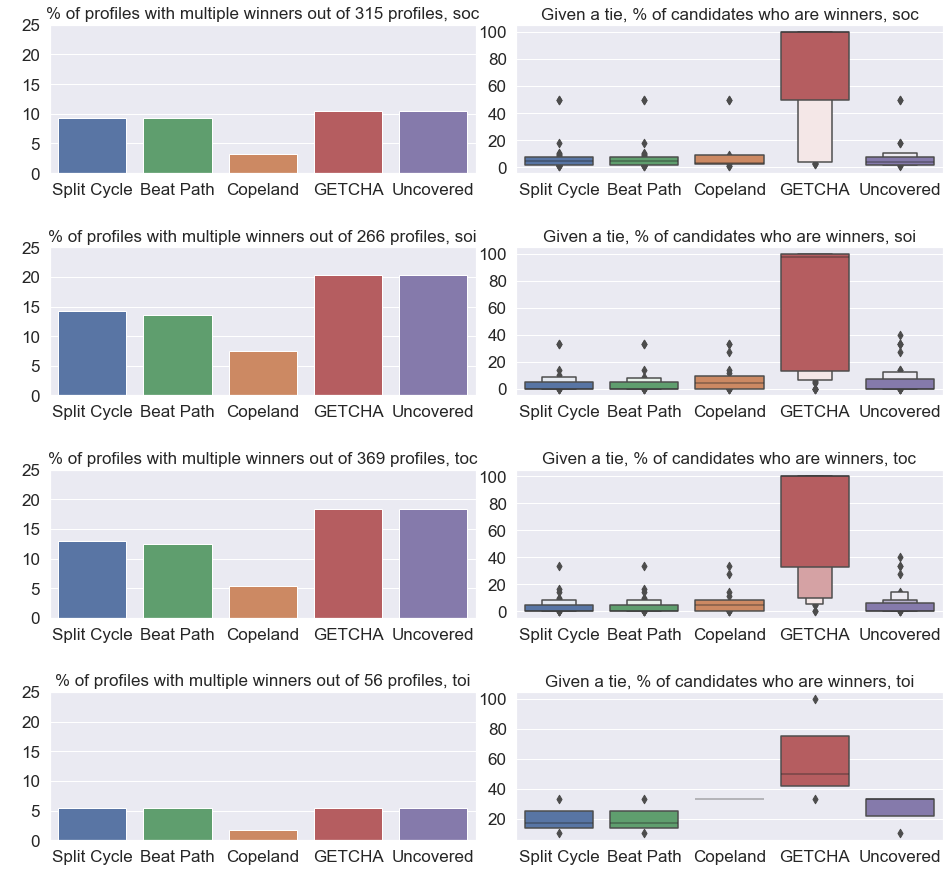

In [20]:
from matplotlib.ticker import MaxNLocator

vms = [
    split_cycle_faster,
    beat_path_faster,
    minimax, 
    copeland,
    uc_gill,
    getcha
]


vms_name = [
    split_cycle_faster.name,
    beat_path_faster.name,
    "GETCHA",
    "Copeland", 
    "Uncovered"
    #plurality
]

current_palette = sns.color_palette()

sc_color = current_palette[0]
copeland_color = current_palette[1]
bp_color = current_palette[2]
smith_color = current_palette[3]
uc_gill_color = current_palette[4]


sns.set()

fig, axs = plt.subplots(nrows = 4, ncols = 2, sharex = False, figsize=(16,15))

e_types = ["soc", "soi", "toc", "toi"]

for eidx, e_type in enumerate(e_types):

    df = pd.read_csv(f"./preflib-data/preflib_data_{e_type}.csv")

    df['vm'] = df["vm"].apply(lambda vmname: vmname if vmname != "Top Cycle" else "GETCHA")
    df['vm'] = df["vm"].apply(lambda vmname: vmname if vmname != "Uncovered Set" else "Uncovered")

    ax = axs[eidx][0]
        
    ys = [(len(list(df[(df["ws_size"] > 1) & (df["vm"] ==  vmn)]["ws_size"])) / len(df[df["vm"] ==  vmn]["ws_size"]) * 100) for vmn in vms_name]
    sns.barplot(x=[vmn for vmn in vms_name], 
                y=ys,
                order = ["Split Cycle", "Beat Path", "Copeland", "GETCHA", "Uncovered"],
                palette = [sc_color, bp_color, copeland_color, smith_color, uc_gill_color],
                ax=ax)
    ax.set_title(f"% of profiles with multiple winners out of {len(df[df['vm'] ==  'Split Cycle']['ws_size'])} profiles, {e_type}", fontsize=17)
    ax.set_ylabel(f" ")
    ax.set_ylim(0,25)
    #ax.get_legend().set_visible(False)
    ax.yaxis.set_major_locator(MaxNLocator(5)) 
    for label in ax.get_yticklabels():
        label.set(fontsize=17)
    for label in ax.get_xticklabels():
        label.set(fontsize=17)

    ax = axs[eidx][1]
    sns.boxenplot(x="vm", 
                  y="p_ws_size",
                  data =df[(df["ws_size"] > 1) & df["vm"].isin(vms_name)],
                  order = ["Split Cycle", "Beat Path", "Copeland", "GETCHA", "Uncovered"],
                  palette = [sc_color, bp_color, copeland_color, smith_color, uc_gill_color],
                      ax = ax)

    ax.set_title(f"Given a tie, % of candidates who are winners, {e_type}", fontsize=17)
    ax.set_ylabel(f" ")
    ax.set_xlabel(f" ")
        #ax.set_ylim(2, num_cands)
    ax.yaxis.set_major_locator(MaxNLocator(6, integer=True))
    for label in ax.get_yticklabels():
        label.set(fontsize=17)
    for label in ax.get_xticklabels():
        label.set(fontsize=17)

    #ax.get_legend().set_visible(False)


    #axs[3][0].set_xlabel(f"Voting Methods", fontsize=16)
    #axs[3][1].set_xlabel(f"Voting Methods", fontsize=16)

# plt.legend(bbox_to_anchor=(-0.075, 6.625), loc='center',
#             ncol=5,  borderaxespad=0.25, fontsize=16)
plt.subplots_adjust(wspace=0.095, hspace=0.5)

plt.savefig(f"./preflib2.pdf", bbox_inches='tight')


##  2009 Mayoral Election in Burlington, Vermont

This is the election discussed in Example 1.2.

The candidates: 
1: Bob Kiss
2: Andy Montroll
3: James Simpson
4: Dan Smith
5: Kurt Wright
6: Write-In


The Condorcet winner is Bob Kiss
Margin Graph


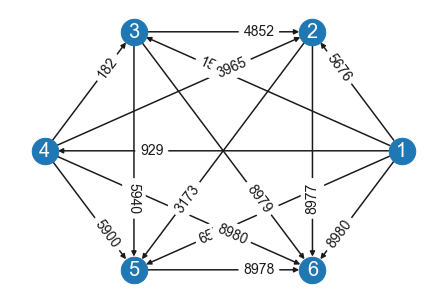

Split Cycle winner: Bob Kiss
Beat Path winner: Bob Kiss
Minimax winner: Bob Kiss
Ranked Pairs winner: Bob Kiss
GETCHA winner: Bob Kiss


In [23]:
candmap, rankmaps, rankmapcounts, numvoters = read_election_file(open("./preflib-data/ED-00005-00000002.toi", "r"))


print("The candidates: ")
for cid,c in candmap.items():
    print(f"{cid}: {c}")

print("\n")

prof = ProfileWithTies(rankmaps, 
                       rcounts = rankmapcounts, 
                       cmap = candmap, 
                       candidates = candmap.keys())

prof.use_extended_strict_preference()
cw = prof.condorcet_winner()
if cw is None: 
    print("There is no Condorcet winner")
else: 
    print(f"The Condorcet winner is {candmap[cw]}")

print("Margin Graph")
prof.display_margin_graph(cmap={c:str(c) for c in candmap.keys()})


vms = [split_cycle, beat_path, minimax, ranked_pairs, getcha]

for vm in vms: 
    
    ws = vm(prof)
    ws_str = ", ".join([candmap[w] for w in ws])
    print(f"{vm.name} winner: {ws_str}")

